<a href="https://colab.research.google.com/github/Prtfw/RL_Causality_Workshop_Intro/blob/master/Intuitive_intro_to_Reinforcement_Learning_%2B_Causality_(2019_RL_Workshop).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
hello world....

Motivation: 
https://www.youtube.com/watch?v=gn4nRCC9TwQ (RL working)
https://www.youtube.com/watch?v=tlOIHko8ySg (RL working??? kind of... it's maximizing rewards but not doing what WE WANT)

the plan:
- the RL framework: https://cl.ly/92c16ebe7e8b
- the RL case study: your manager comes to you... 3 buttons, which one has highest conversion/click through rate? (a.k.a multi armed-bandits https://cl.ly/5de4304f2028)
- traditional a/b testing solution + expected results
- the explore / exploit solution (epsilon greedy)
- a better solution (minimize regret)
       - UCB1 [https://cl.ly/ffaf21b97368; https://banditalgs.com/2016/09/18/the-upper-confidence-bound-algorithm/]
       - Thompson sampling 
       - for comparison between the 2 above see: [NIPS 2011 ("An empirical evaluation of Thompson Sampling") | https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf]
       
- beyond correlations/pattern matching, the question of "why", climbing the ladder of "intelligence/knowledge":
       - dealing with confounders: if your results tell you "option a" is better... can you trust it? Maybe not... maybe a confounding variable is at play which won't apply when you deploy. 
          (The worst part is you even won't know the counterfactual.)
       - how to prevent this?
          - list and condition on all potential confounder and values: number state space explodes :(, data become too sparse
          - a potentially better way: factorize the potential latent vars (as if they are a embedding), use them as a new feature in predictive model [NIPS 2018: ("The Blessings of Multiple Causes") [https://arxiv.org/abs/1805.06826]

Today: 
    - code up environment
    - code up agent
      - act
      - evaluate
      - update
    - code up explore vs exploit
    - experiment with different learning algorithms and parameters
    
Goals: 
    - you understand the RL framework at it's core (everything else is doing the same thing but slight differently and potentially better with more complexity i.e. DQNs/A3C/Hierarchical RL)
    - you have code that works that you can play around with
    - you have a way to experiment and build intuition quickly
    - you have leads to pursue should you be interested contributing to this line of research
    - you have a 60% coverage/survey from the basics of RL => select state of the art results in < 1hr.
    - lets roll?!

Open questions:
    - how well are we doing? (Regret: your theoretical reward if you knew all along the optimal moves minus what you got. "had I known (everything)... I would have gotten [x] more reward". x = regret )
    - how confident are we? can we calculate "confidence intervals"?
    - how we can minimize regret? decreasing the explore rate is a good idea: try some kind of decay function or look up or as homework: implement "UCB1"

Next:
    - use cases in real life... how can we use this?
    - (online a/b testing)
    - when is online learning / RL appropriate / not appropriate

    

Definitions (you fill this in for yourself)

Agent:

Environment:
    
State:
    
Reward:
    
How:
    

'''

'\nMotivation: \nhttps://www.youtube.com/watch?v=gn4nRCC9TwQ (RL working)\nhttps://www.youtube.com/watch?v=tlOIHko8ySg (RL working??? kind of... it\'s maximizing rewards but not doing what WE WANT)\n\nthe plan:\n- the RL framework: https://cl.ly/92c16ebe7e8b\n- the RL case study: your manager comes to you... 3 buttons, which one has highest conversion/click through rate? (a.k.a multi armed-bandits https://cl.ly/5de4304f2028)\n- traditional a/b testing solution + expected results\n- the explore / exploit solution (epsilon greedy)\n- a better solution (minimize regret)\n       - UCB1 [https://cl.ly/ffaf21b97368; https://banditalgs.com/2016/09/18/the-upper-confidence-bound-algorithm/]\n       - Thompson sampling \n       - for comparison between the 2 above see: [NIPS 2011 ("An empirical evaluation of Thompson Sampling") | https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf]\n       \n- beyond correlations/pattern matching, the question of "why", climbing th

In [0]:
'''

Env: 
    - some number of slot machine, say 3
    - each with different rate of win (bernoulli variable)
    
State:
    - win vs not win
    - 1 vs 0 reward
    
Actions:
    - which slot machine to pull? (bandit 0, 1 or 2)

Agent:
    - select a machine (explore vs exploit)
    - pull the arm (interact with the env, get reward and state)
    - evaluate how well we did
    - update (update so you can make a better choice)
    
'''

'\n\nEnv: \n    - some number of slot machine, say 3\n    - each with different rate of win (bernoulli variable)\n    \nState:\n    - win vs not win\n    - 1 vs 0 reward\n    \nActions:\n    - which slot machine to pull? (bandit 0, 1 or 2)\n\nAgent:\n    - select a machine (explore vs exploit)\n    - pull the arm (interact with the env, get reward and state)\n    - evaluate how well we did\n    - update (update so you can make a better choice)\n    \n'

In [0]:
from scipy.stats import bernoulli, poisson, norm, expon
import numpy as np
from random import randint
%matplotlib inline
import matplotlib.pyplot as plt


class env_model():
  def __init__(self, slots=[.1,.6,.8]):
    self.slots = slots
    self.action_space = list(range(len(slots)))
  
  def pull(self, slot_idx):
    # note this function returns both state and reward 
    # reward = value of bernoulli rand var
    # state: (keep it simple) if reward is 1 then state is "win", else "not win"
    '''@student: a  bernoulli random variable according to the slot expected rate of win'''
    
    return bernoulli.rvs(self.slots[slot_idx]) 

env = env_model()
env.action_space # verify the action space

[0, 1, 2]

In [0]:
def exlore_vs_exploit(explore_ratio):
  return bernoulli.rvs(explore_ratio) 

In [0]:

import scipy.stats as ss
from IPython.display import clear_output
from IPython import display

class agent_epsilon_greedy(): 
    def __init__(self, env, explore_ratio = 0.25):
      self.env = env
      self.explore_ratio = explore_ratio
      self.action_space = env.action_space
      self.so_far = [0]*len(self.action_space)
      self.time_step = 0
      self.total_score = 0
      
    def act(self):
      greedy_action = np.argmax(self.so_far)
      selected_action = greedy_action
      should_explore = exlore_vs_exploit(self.explore_ratio)
      if should_explore or self.time_step==0:
        selected_action = randint(0, len(self.action_space)-1)
      reward = env.pull(selected_action)
      self.time_step+=1
      self.total_score +=reward
      return (selected_action, reward)
      
    def evaluate_n_update(self, prev_action, reward):
      n = self.time_step
      prev = self.so_far[prev_action]
      '''@student: implement parametric mean''' #think weighted average, keep it simple for now
      self.so_far[prev_action] = prev*(n-1)/n + reward/n 
      
    def reset(self):
      '''@student: implement state reset so we can play another game "from scratch" with a "fresh initial state" '''
      # think about how you restart a game so it's fair, we do not want to learn from "game to game"
 
      self.so_far = [0]*len(self.action_space)
      self.time_step = 0
      self.total_score = 0
      
    def draw_plot(self):
      pass
      
class agent_thompson(): # thompson sampling version of the agent
    def __init__(self, env):
      self.env = env
      self.action_space = env.action_space
      # initialize with "uninformative" beta prior, because we assume no prior knowledge of the environment
      # the ratio of the first/2nd param affects the shape of the beta distribution, you will see how in the visualizations later

      self.so_far = [(1, 1)]*len(self.action_space) 
      self.time_step = 0
      self.total_score = 0
      
    def act(self):
      samples_from_beta_distr = {}
      for k in self.action_space:
        samples_from_beta_distr[k] = np.random.beta(self.so_far[k][0], self.so_far[k][1])
#       print('samples_from_beta_distr', samples_from_beta_distr)
      selected_action = max(samples_from_beta_distr, key=samples_from_beta_distr.get)
      reward = env.pull(selected_action)
      self.time_step+=1
      self.total_score +=reward
      return (selected_action, reward)
      
    def evaluate_n_update(self, prev_action, reward):
      # update using beta bernoulli conjugacy: it's just a mathematical convinience / efficient / beautiful that both functions have the same analytical form, we don't "need it"
      # see: https://en.wikipedia.org/wiki/Conjugate_prior for more info
      n = self.time_step
      prev_a, prev_b = self.so_far[prev_action]
      self.so_far[prev_action] = (prev_a+reward, prev_b + 1 - reward)
      
    def reset(self):
      '''@student: implement state reset so we can play another game "from scratch" with a "fresh initial state" '''
      # think about how you restart a game so it's fair, we do not want to learn from "game to game" (that's cheating! - from a experimentation perspective)
 
      self.so_far = [(1, 1)]*len(self.action_space)
      self.time_step = 0
      self.total_score = 0
      
    def draw_plot(self):
        fig = plt.figure()
        fig.canvas.draw()
        plt.xlim(0,1)
        x = np.linspace(0,1,100)
        tempy = []
        for idx in range(len(self.so_far)):
            a = self.so_far[idx][0]
            b = self.so_far[idx][1]
            y = ss.beta.pdf(x, a,b)
            plt.plot(x,y,label=idx)
        plt.ylim(0,30)
        plt.legend()
        plt.title('@ time_step: {}'.format(self.time_step-1))
        display.display(plt.gcf())
      

no_regret_score 800.0
base_case_regret 300.0


~~~~~~~~~~~~~~~~~~~~~~ROUND__0~~~~~~~~~~~~~~~~~~~~~~~~


time_step 0 ===========>
before update guesses [(1, 1), (1, 1), (1, 1)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 1), (1, 1), (2, 1)]


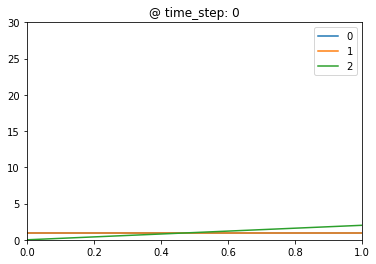


time_step 50 ===========>
before update guesses [(1, 4), (2, 7), (28, 14)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (29, 14)]


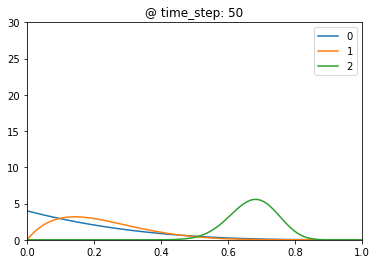


time_step 100 ===========>
before update guesses [(1, 4), (2, 7), (65, 27)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (66, 27)]


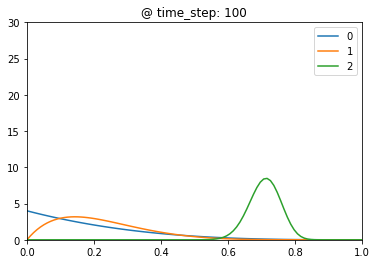


time_step 150 ===========>
before update guesses [(1, 4), (2, 7), (101, 41)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (102, 41)]


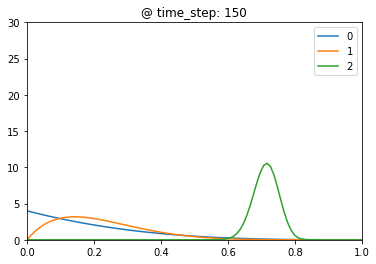


time_step 200 ===========>
before update guesses [(1, 4), (2, 7), (140, 52)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 4), (2, 7), (140, 53)]


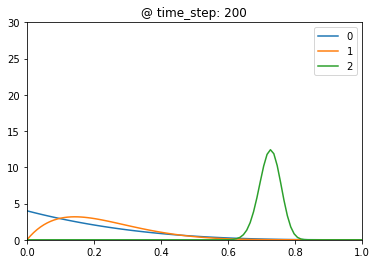


time_step 250 ===========>
before update guesses [(1, 4), (2, 7), (179, 63)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (180, 63)]


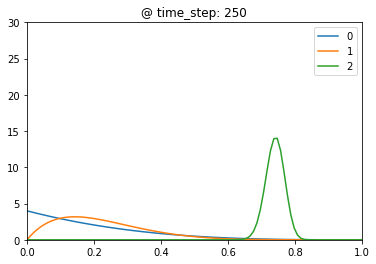


time_step 300 ===========>
before update guesses [(1, 4), (2, 7), (223, 69)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (224, 69)]


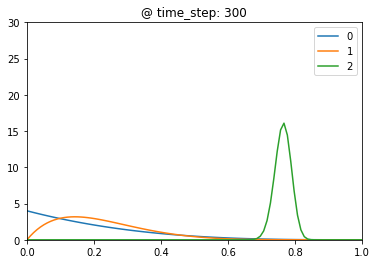


time_step 350 ===========>
before update guesses [(1, 4), (2, 7), (266, 76)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (267, 76)]


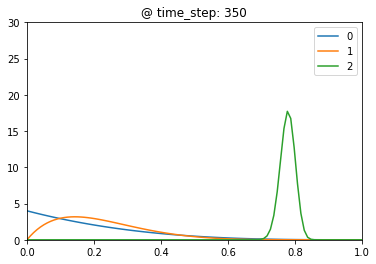


time_step 400 ===========>
before update guesses [(1, 4), (2, 7), (305, 87)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (306, 87)]


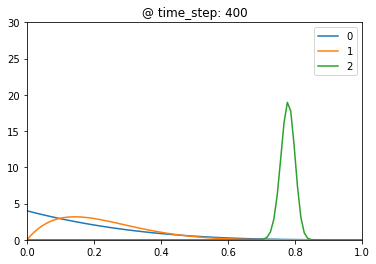


time_step 450 ===========>
before update guesses [(1, 4), (2, 7), (341, 101)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (342, 101)]


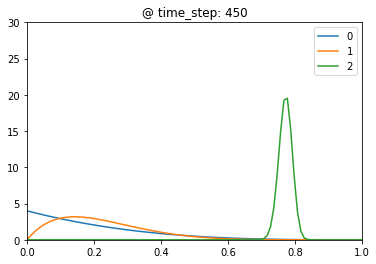


time_step 500 ===========>
before update guesses [(1, 4), (2, 7), (379, 113)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (380, 113)]


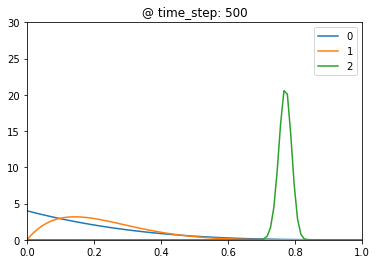


time_step 550 ===========>
before update guesses [(1, 4), (2, 7), (419, 123)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 4), (2, 7), (419, 124)]


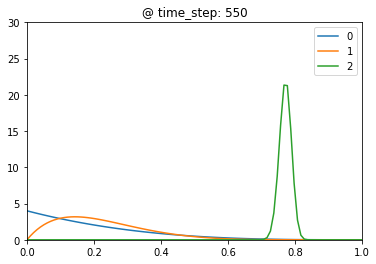


time_step 600 ===========>
before update guesses [(1, 4), (2, 7), (460, 132)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (461, 132)]


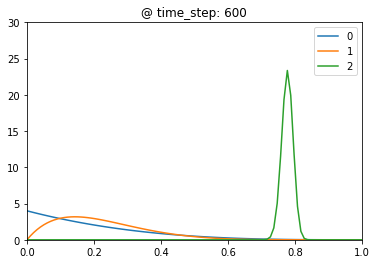


time_step 650 ===========>
before update guesses [(1, 4), (2, 7), (501, 141)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (502, 141)]


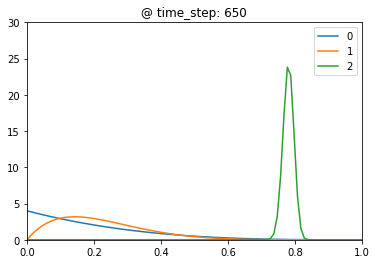


time_step 700 ===========>
before update guesses [(1, 4), (2, 7), (535, 157)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (536, 157)]


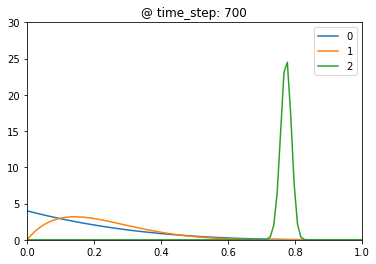


time_step 750 ===========>
before update guesses [(1, 4), (2, 7), (580, 162)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (581, 162)]


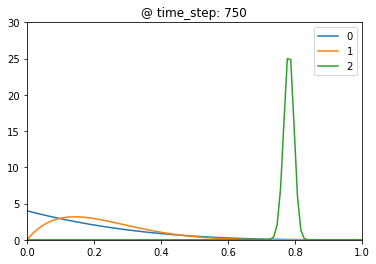


time_step 800 ===========>
before update guesses [(1, 4), (2, 7), (620, 172)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (621, 172)]


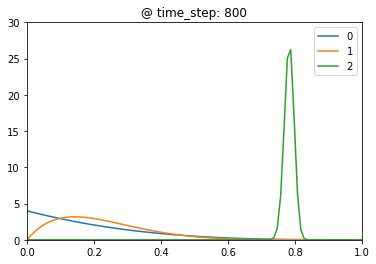


time_step 850 ===========>
before update guesses [(1, 4), (2, 7), (663, 179)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (664, 179)]


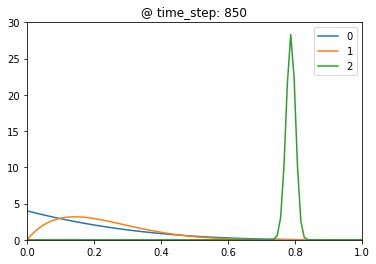


time_step 900 ===========>
before update guesses [(1, 4), (2, 7), (708, 184)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (709, 184)]


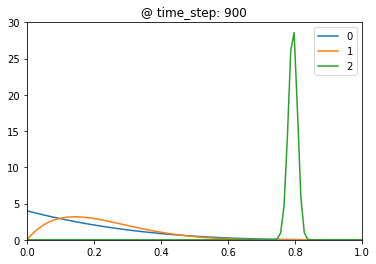


time_step 950 ===========>
before update guesses [(1, 4), (2, 7), (747, 195)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (2, 7), (748, 195)]


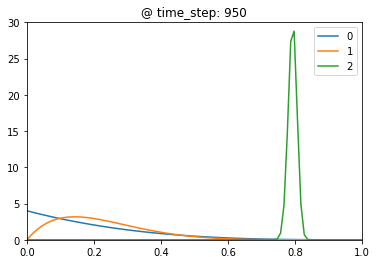



agent total score 787
agent final estimates [(1, 4), (2, 7), (787, 205)]

regret_round_0 = 13.0


~~~~~~~~~~~~~~~~~~~~~~ROUND__1~~~~~~~~~~~~~~~~~~~~~~~~


time_step 0 ===========>
before update guesses [(1, 1), (1, 1), (1, 1)]
action / pulled bandit:  1 got reward:  0
updated guesses [(1, 1), (1, 2), (1, 1)]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


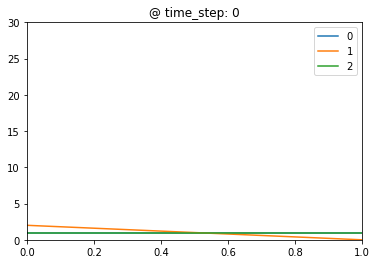


time_step 50 ===========>
before update guesses [(1, 3), (2, 2), (41, 7)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 3), (2, 2), (41, 8)]


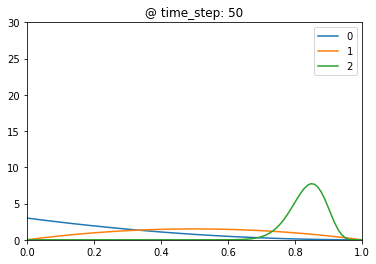


time_step 100 ===========>
before update guesses [(1, 3), (5, 3), (73, 21)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 3), (5, 3), (74, 21)]


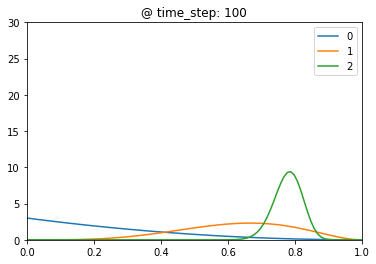


time_step 150 ===========>
before update guesses [(2, 4), (8, 5), (107, 30)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 4), (8, 5), (108, 30)]


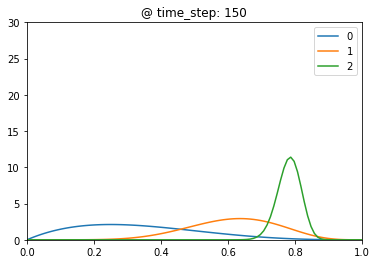


time_step 200 ===========>
before update guesses [(2, 4), (10, 9), (142, 39)]
action / pulled bandit:  1 got reward:  1
updated guesses [(2, 4), (11, 9), (142, 39)]


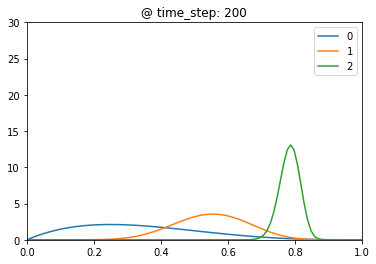


time_step 250 ===========>
before update guesses [(2, 5), (12, 9), (179, 49)]
action / pulled bandit:  2 got reward:  0
updated guesses [(2, 5), (12, 9), (179, 50)]


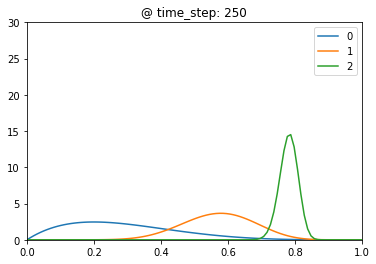


time_step 300 ===========>
before update guesses [(2, 5), (14, 10), (215, 60)]
action / pulled bandit:  2 got reward:  0
updated guesses [(2, 5), (14, 10), (215, 61)]


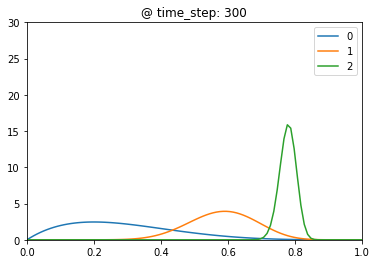


time_step 350 ===========>
before update guesses [(2, 5), (16, 10), (251, 72)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 5), (16, 10), (252, 72)]


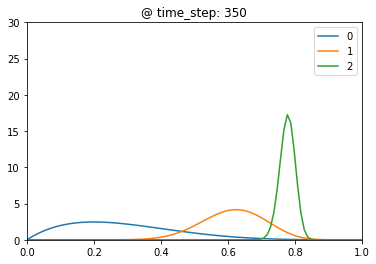


time_step 400 ===========>
before update guesses [(2, 5), (16, 10), (292, 81)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 5), (16, 10), (293, 81)]


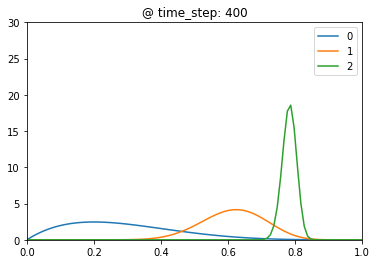


time_step 450 ===========>
before update guesses [(2, 5), (17, 11), (330, 91)]
action / pulled bandit:  2 got reward:  0
updated guesses [(2, 5), (17, 11), (330, 92)]


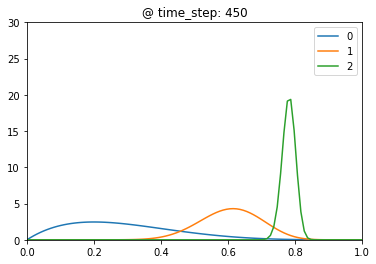


time_step 500 ===========>
before update guesses [(2, 5), (17, 11), (375, 96)]
action / pulled bandit:  2 got reward:  0
updated guesses [(2, 5), (17, 11), (375, 97)]


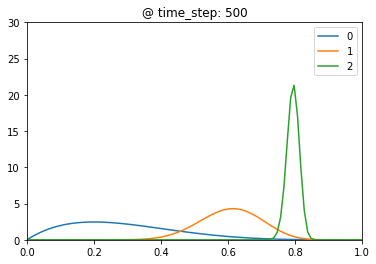


time_step 550 ===========>
before update guesses [(2, 5), (18, 11), (413, 107)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 5), (18, 11), (414, 107)]


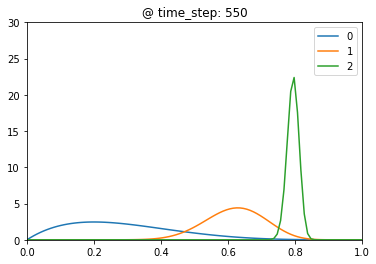


time_step 600 ===========>
before update guesses [(2, 5), (18, 11), (452, 118)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 5), (18, 11), (453, 118)]


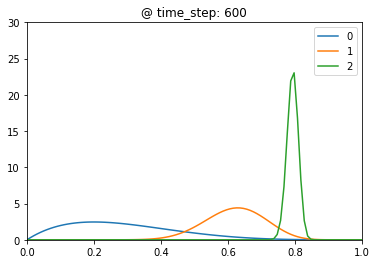


time_step 650 ===========>
before update guesses [(2, 6), (18, 11), (490, 129)]
action / pulled bandit:  2 got reward:  0
updated guesses [(2, 6), (18, 11), (490, 130)]


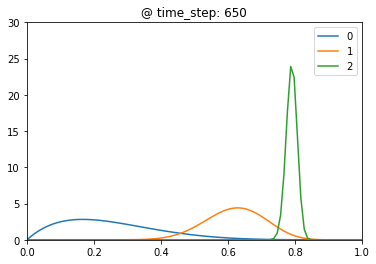


time_step 700 ===========>
before update guesses [(2, 6), (19, 11), (529, 139)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 6), (19, 11), (530, 139)]


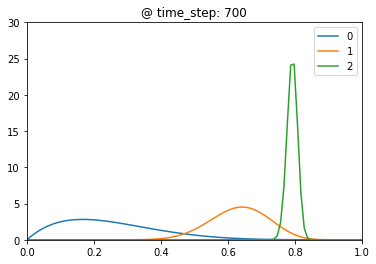


time_step 750 ===========>
before update guesses [(2, 6), (19, 12), (566, 151)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 6), (19, 12), (567, 151)]


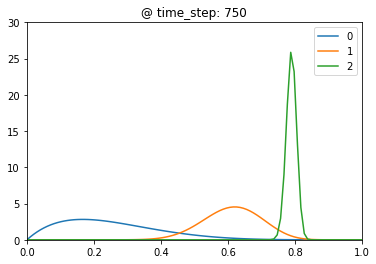


time_step 800 ===========>
before update guesses [(2, 6), (19, 13), (607, 159)]
action / pulled bandit:  2 got reward:  0
updated guesses [(2, 6), (19, 13), (607, 160)]


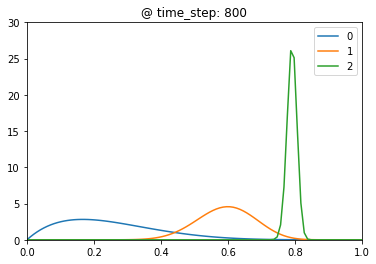


time_step 850 ===========>
before update guesses [(2, 6), (19, 13), (642, 174)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 6), (19, 13), (643, 174)]


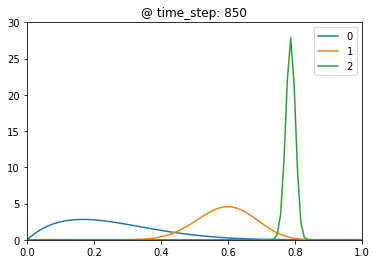


time_step 900 ===========>
before update guesses [(2, 6), (19, 13), (684, 182)]
action / pulled bandit:  2 got reward:  1
updated guesses [(2, 6), (19, 13), (685, 182)]


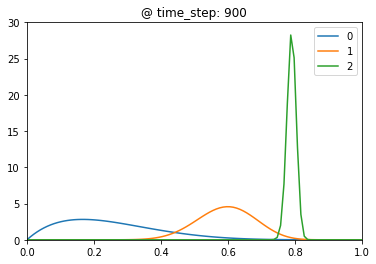


time_step 950 ===========>
before update guesses [(2, 6), (19, 13), (722, 194)]
action / pulled bandit:  2 got reward:  0
updated guesses [(2, 6), (19, 13), (722, 195)]


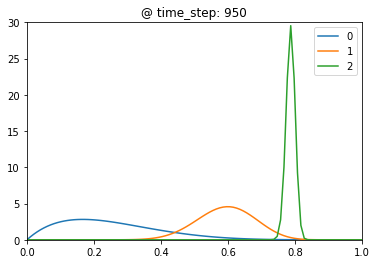



agent total score 783
agent final estimates [(2, 6), (19, 13), (765, 201)]

regret_round_1 = 17.0


trial_0 || base_case_regret - current_regret => less regret :  285.0  =  300.0  -  15.0




~~~~~~~~~~~~~~~~~~~~~~ROUND__0~~~~~~~~~~~~~~~~~~~~~~~~


time_step 0 ===========>
before update guesses [(1, 1), (1, 1), (1, 1)]
action / pulled bandit:  1 got reward:  1
updated guesses [(1, 1), (2, 1), (1, 1)]


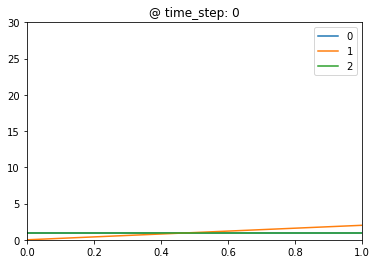


time_step 50 ===========>
before update guesses [(1, 4), (7, 10), (25, 9)]
action / pulled bandit:  1 got reward:  1
updated guesses [(1, 4), (8, 10), (25, 9)]


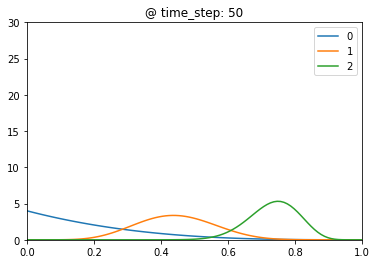


time_step 100 ===========>
before update guesses [(1, 4), (8, 10), (66, 17)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (8, 10), (67, 17)]


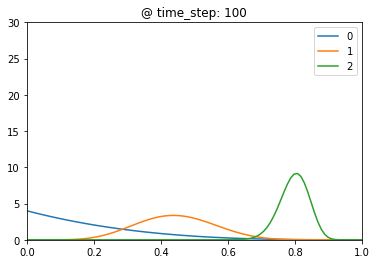


time_step 150 ===========>
before update guesses [(1, 4), (8, 10), (105, 28)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (8, 10), (106, 28)]


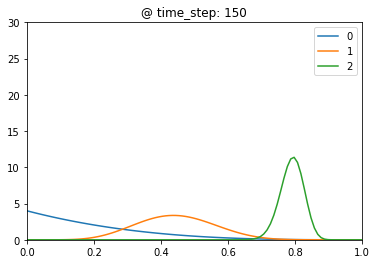


time_step 200 ===========>
before update guesses [(1, 4), (8, 10), (143, 40)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (8, 10), (144, 40)]


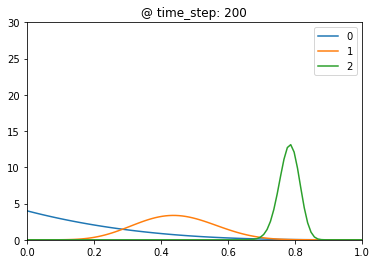


time_step 250 ===========>
before update guesses [(1, 5), (8, 10), (183, 49)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (184, 49)]


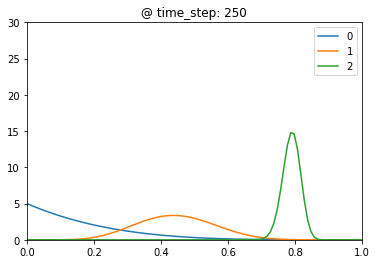


time_step 300 ===========>
before update guesses [(1, 5), (8, 10), (224, 58)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (225, 58)]


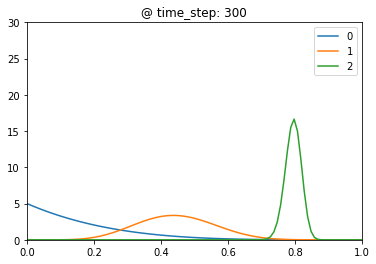


time_step 350 ===========>
before update guesses [(1, 5), (8, 10), (263, 69)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (264, 69)]


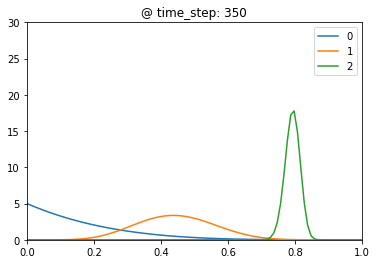


time_step 400 ===========>
before update guesses [(1, 5), (8, 10), (304, 78)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 5), (8, 10), (304, 79)]


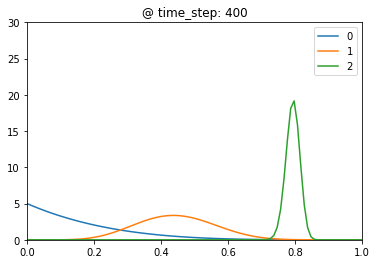


time_step 450 ===========>
before update guesses [(1, 5), (8, 10), (344, 88)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (345, 88)]


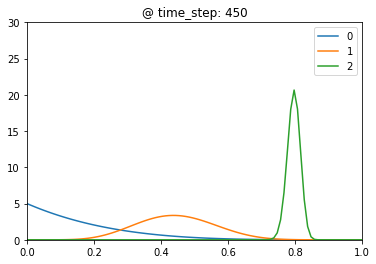


time_step 500 ===========>
before update guesses [(1, 5), (8, 10), (385, 97)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (386, 97)]


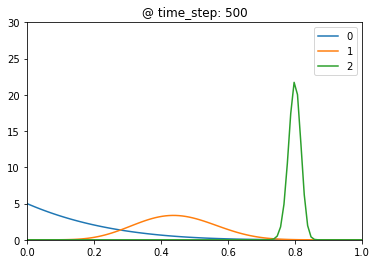


time_step 550 ===========>
before update guesses [(1, 5), (8, 10), (427, 105)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 5), (8, 10), (427, 106)]


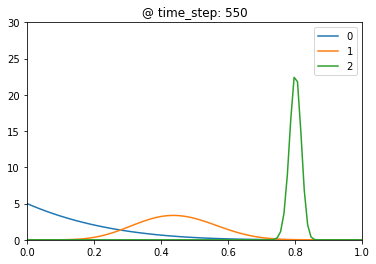


time_step 600 ===========>
before update guesses [(1, 5), (8, 10), (469, 113)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (470, 113)]


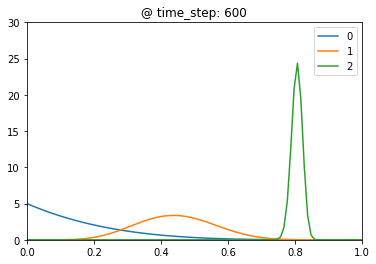


time_step 650 ===========>
before update guesses [(1, 5), (8, 10), (506, 126)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (507, 126)]


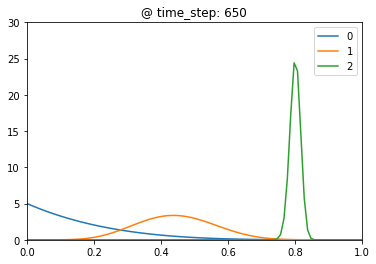


time_step 700 ===========>
before update guesses [(1, 5), (8, 10), (542, 140)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (543, 140)]


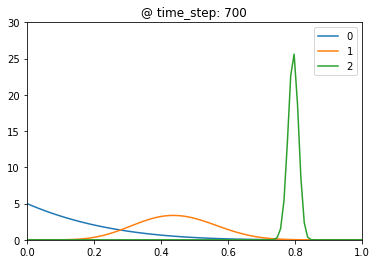


time_step 750 ===========>
before update guesses [(1, 5), (8, 10), (576, 156)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (577, 156)]


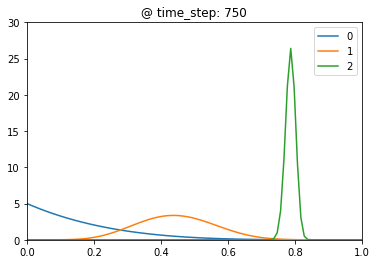


time_step 800 ===========>
before update guesses [(1, 5), (8, 10), (616, 166)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (617, 166)]


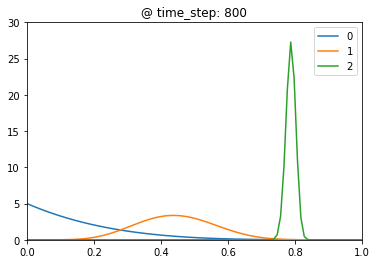


time_step 850 ===========>
before update guesses [(1, 5), (8, 10), (660, 172)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (661, 172)]


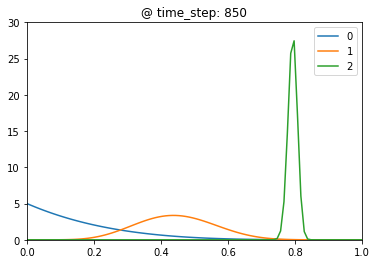


time_step 900 ===========>
before update guesses [(1, 5), (8, 10), (695, 187)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (696, 187)]


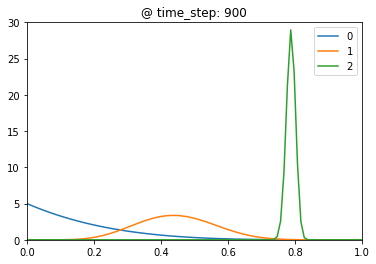


time_step 950 ===========>
before update guesses [(1, 5), (8, 10), (735, 197)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (8, 10), (736, 197)]


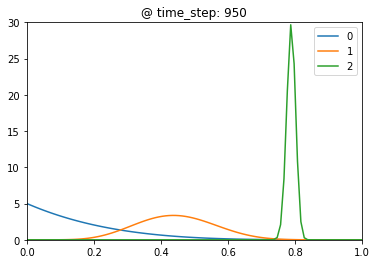



agent total score 782
agent final estimates [(1, 5), (8, 10), (776, 206)]

regret_round_0 = 18.0


~~~~~~~~~~~~~~~~~~~~~~ROUND__1~~~~~~~~~~~~~~~~~~~~~~~~


time_step 0 ===========>
before update guesses [(1, 1), (1, 1), (1, 1)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 1), (1, 1), (2, 1)]


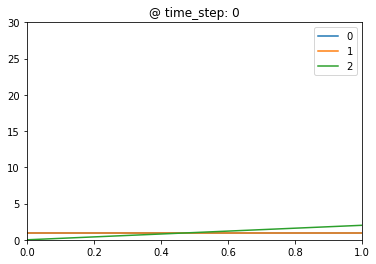


time_step 50 ===========>
before update guesses [(1, 3), (15, 8), (21, 8)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 3), (15, 8), (21, 9)]


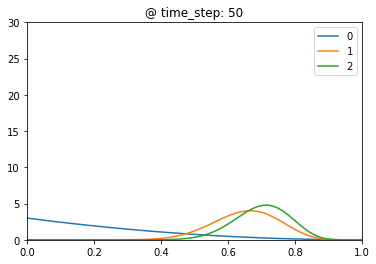


time_step 100 ===========>
before update guesses [(1, 4), (23, 11), (48, 19)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (23, 11), (49, 19)]


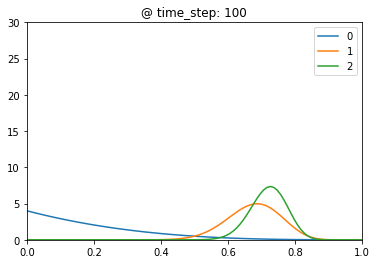


time_step 150 ===========>
before update guesses [(1, 4), (27, 15), (82, 27)]
action / pulled bandit:  1 got reward:  0
updated guesses [(1, 4), (27, 16), (82, 27)]


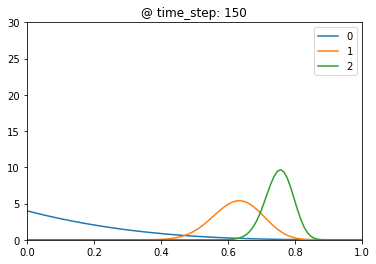


time_step 200 ===========>
before update guesses [(1, 4), (29, 17), (118, 37)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (29, 17), (119, 37)]


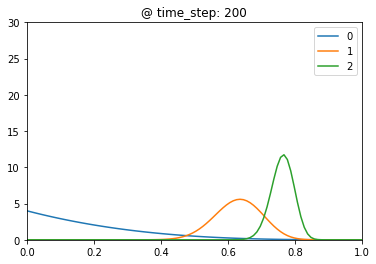


time_step 250 ===========>
before update guesses [(1, 4), (30, 18), (153, 50)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (30, 18), (154, 50)]


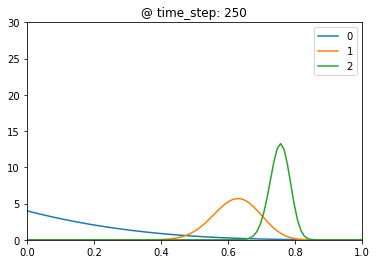


time_step 300 ===========>
before update guesses [(1, 4), (32, 19), (193, 57)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (32, 19), (194, 57)]


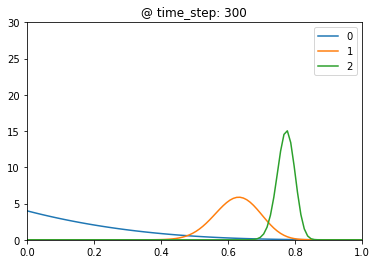


time_step 350 ===========>
before update guesses [(1, 4), (32, 19), (233, 67)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (32, 19), (234, 67)]


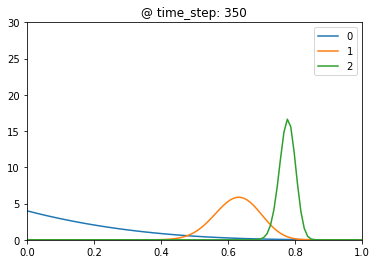


time_step 400 ===========>
before update guesses [(1, 4), (32, 19), (275, 75)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 4), (32, 19), (275, 76)]


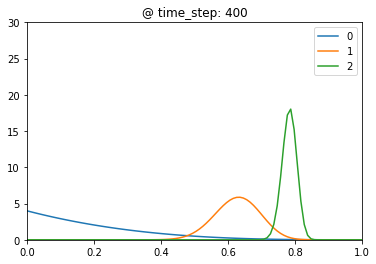


time_step 450 ===========>
before update guesses [(1, 4), (33, 19), (317, 82)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (33, 19), (318, 82)]


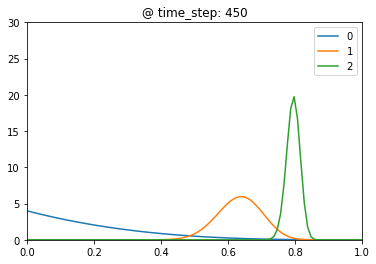


time_step 500 ===========>
before update guesses [(1, 4), (33, 19), (360, 89)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 4), (33, 19), (361, 89)]


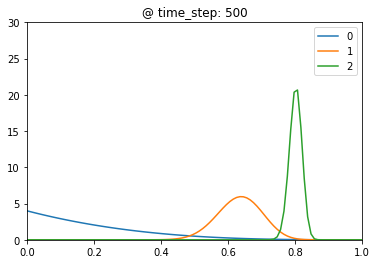


time_step 550 ===========>
before update guesses [(1, 5), (33, 19), (396, 102)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 5), (33, 19), (396, 103)]


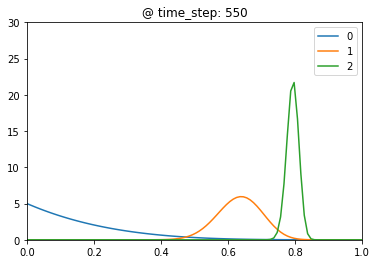


time_step 600 ===========>
before update guesses [(1, 5), (33, 19), (435, 113)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (33, 19), (436, 113)]


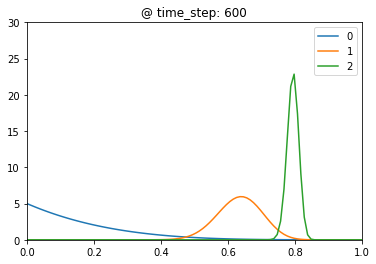


time_step 650 ===========>
before update guesses [(1, 5), (33, 19), (475, 123)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (33, 19), (476, 123)]


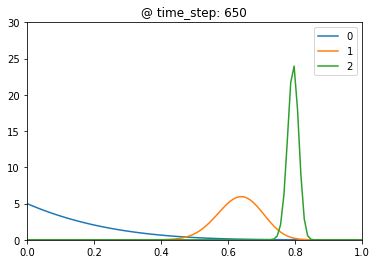


time_step 700 ===========>
before update guesses [(1, 5), (33, 19), (512, 136)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 5), (33, 19), (512, 137)]


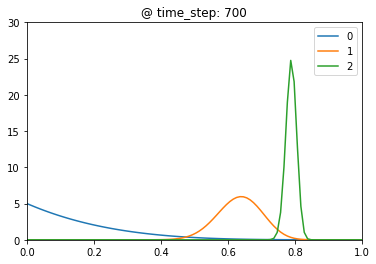


time_step 750 ===========>
before update guesses [(1, 5), (33, 19), (548, 150)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (33, 19), (549, 150)]


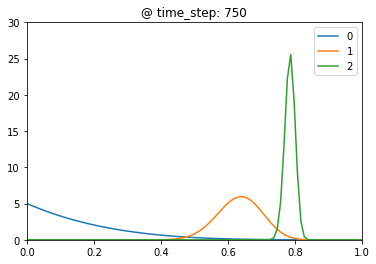


time_step 800 ===========>
before update guesses [(1, 5), (33, 21), (586, 160)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (33, 21), (587, 160)]


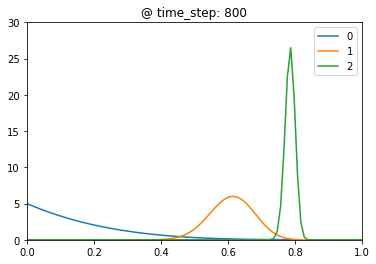


time_step 850 ===========>
before update guesses [(1, 5), (33, 21), (622, 174)]
action / pulled bandit:  2 got reward:  0
updated guesses [(1, 5), (33, 21), (622, 175)]


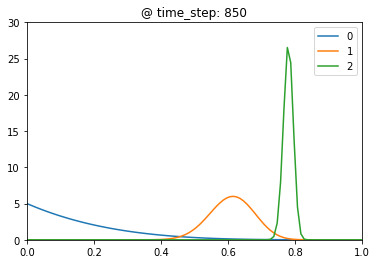


time_step 900 ===========>
before update guesses [(1, 5), (33, 21), (654, 192)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (33, 21), (655, 192)]


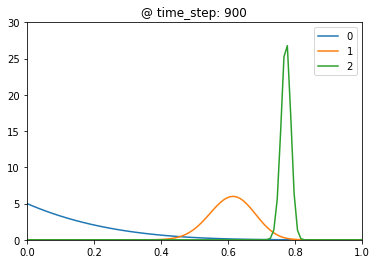


time_step 950 ===========>
before update guesses [(1, 5), (33, 21), (691, 205)]
action / pulled bandit:  2 got reward:  1
updated guesses [(1, 5), (33, 21), (692, 205)]


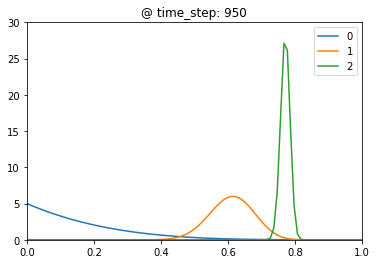



agent total score 762
agent final estimates [(1, 5), (33, 21), (731, 215)]

regret_round_1 = 38.0


trial_1 || base_case_regret - current_regret => less regret :  278.5  =  300.0  -  21.5


avg_regrets_for_all_trials 18.25


'\nNotes and Questions you should think about: \n\n- Observe the "guesses" being updated based on real time data\n- Obsserve that the \'guesses\' tend towards the true value that we have set in the env\n- Verify for yourself that the agent never "knows" the true values other than what the stochastic environment is providing as rewards\n- Which agent performs better? And why?\n- What if you move the env params closer? If the difference is smaller, do we still converge to the right answer? When does this matter / not matter?\n- What does the "peakiness" (kurtosis) of the various distribution mean? what does the horizontal location of the distribution mean?\n'

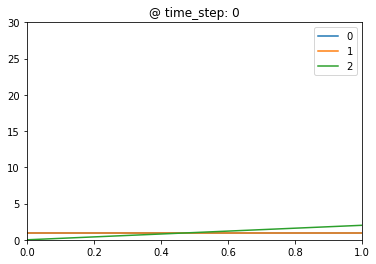

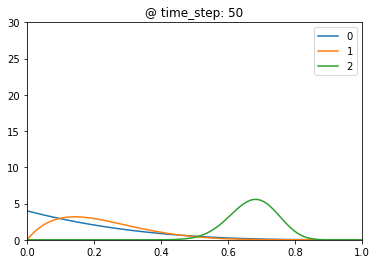

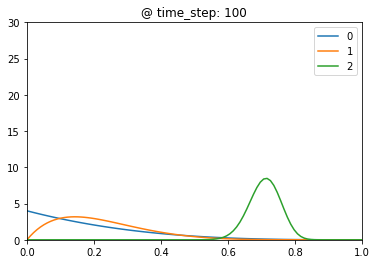

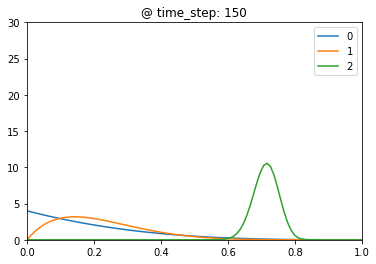

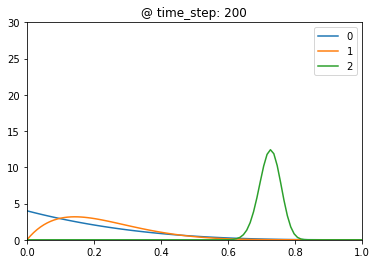

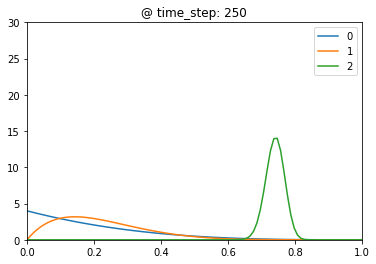

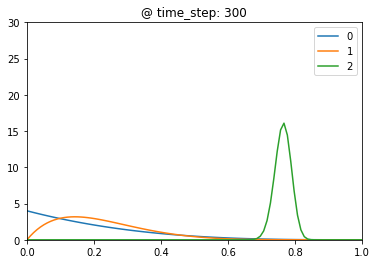

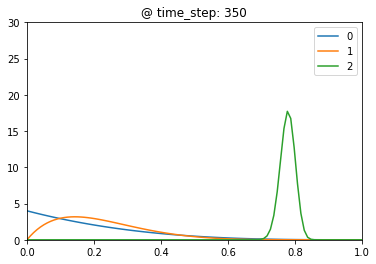

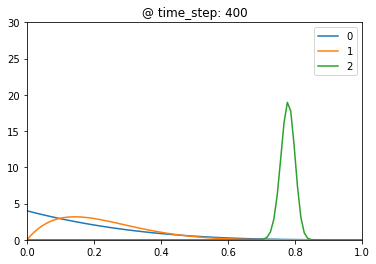

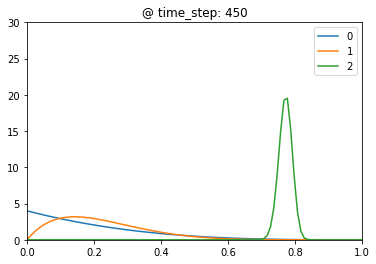

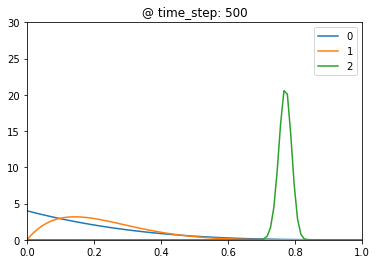

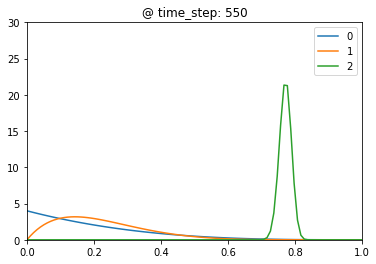

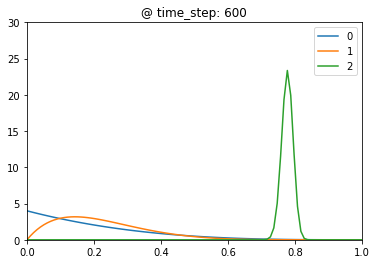

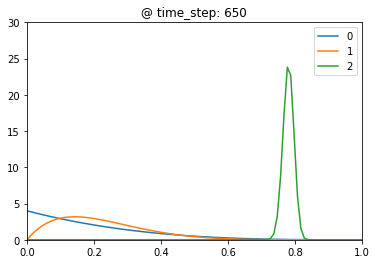

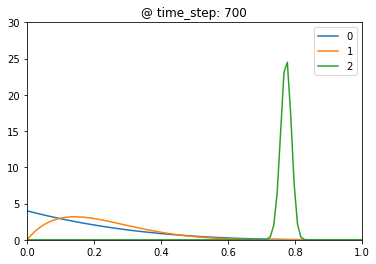

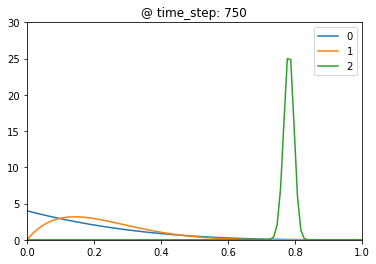

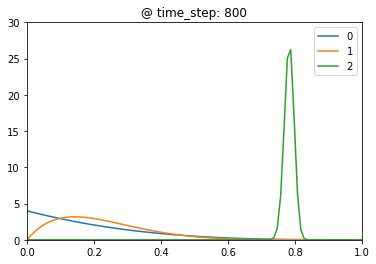

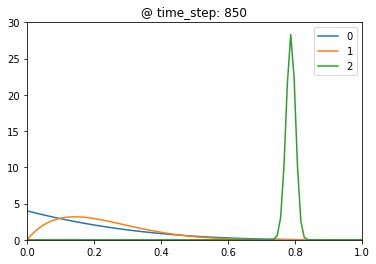

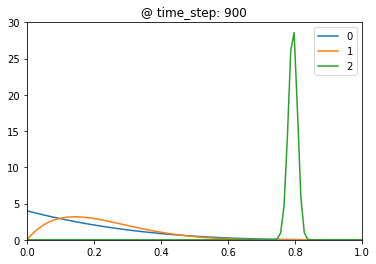

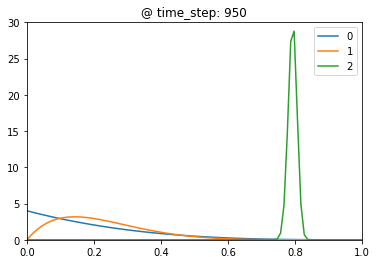

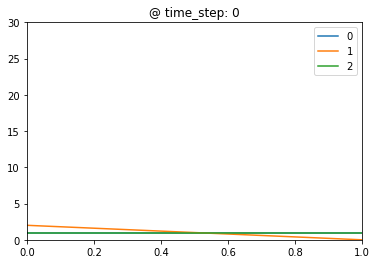

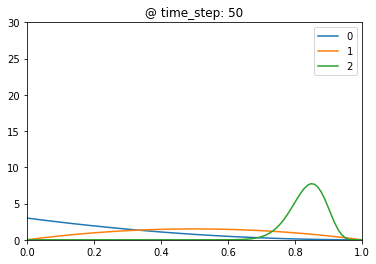

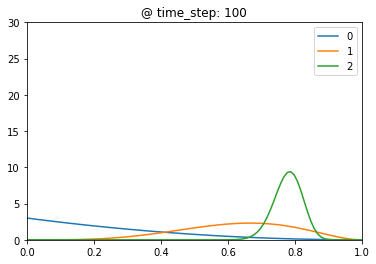

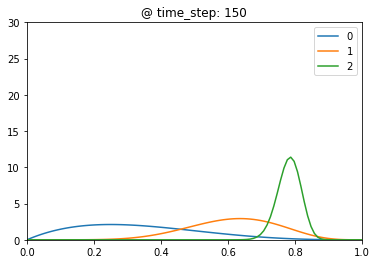

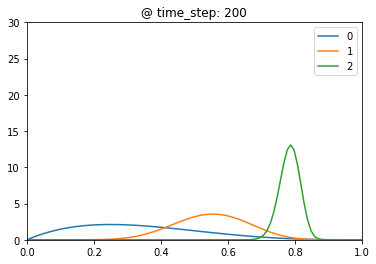

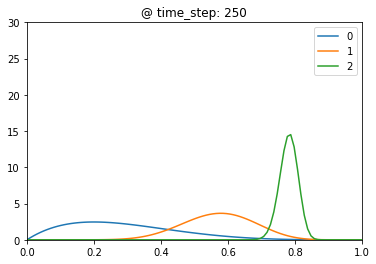

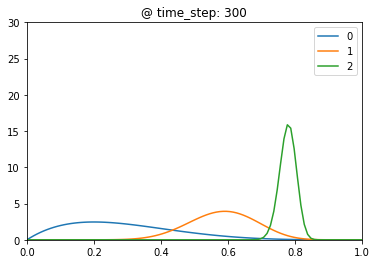

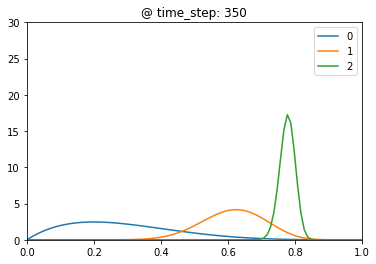

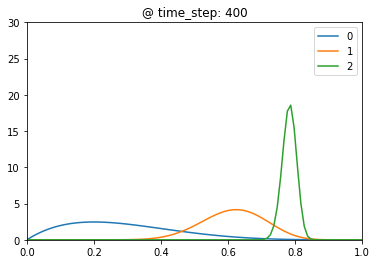

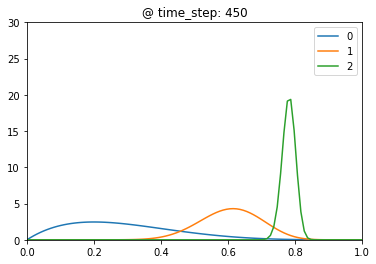

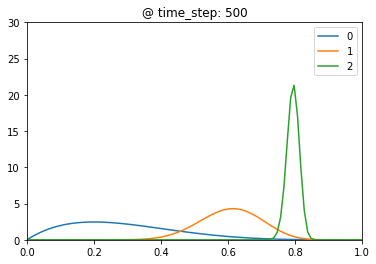

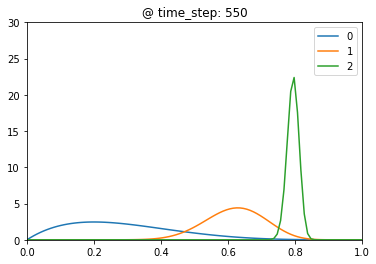

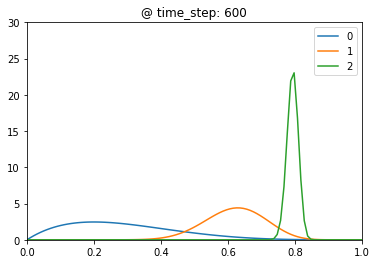

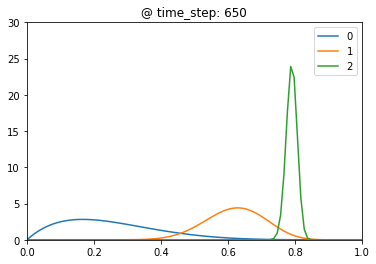

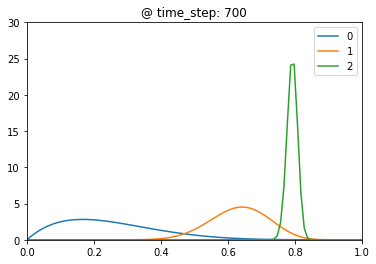

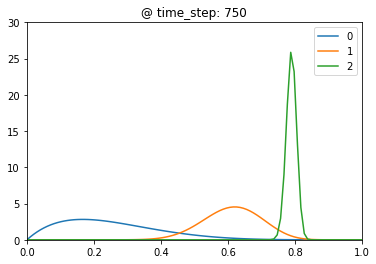

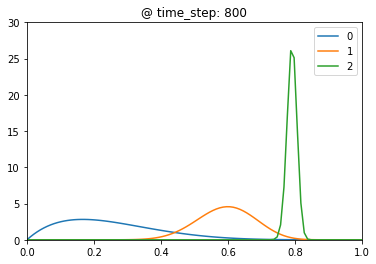

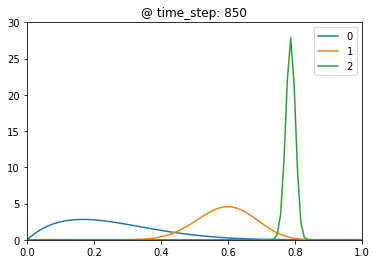

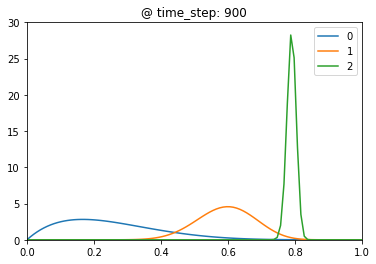

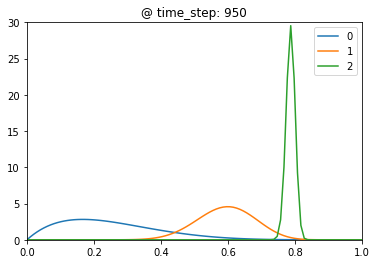

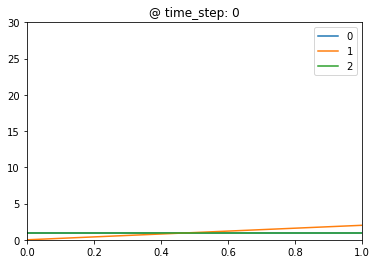

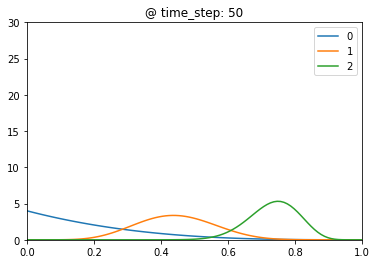

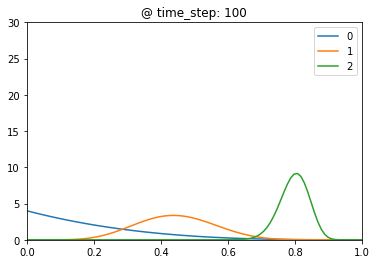

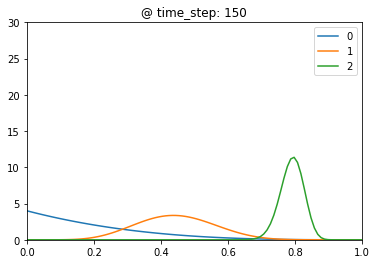

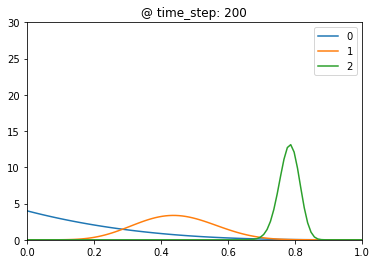

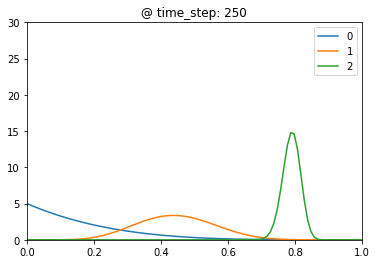

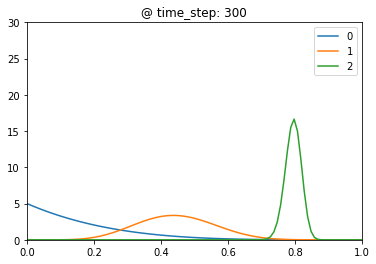

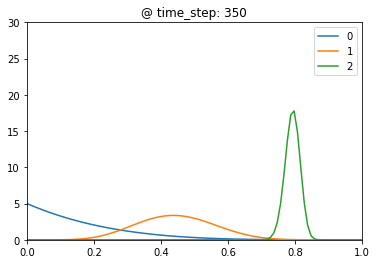

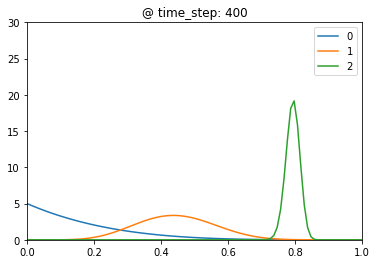

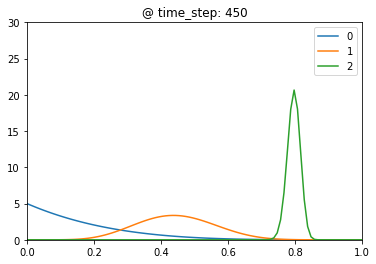

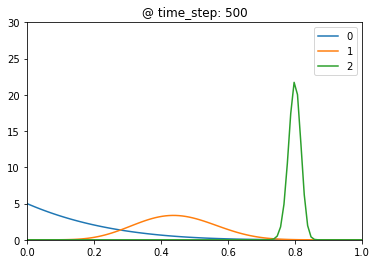

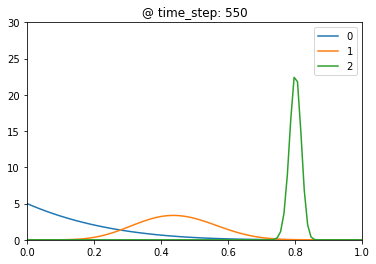

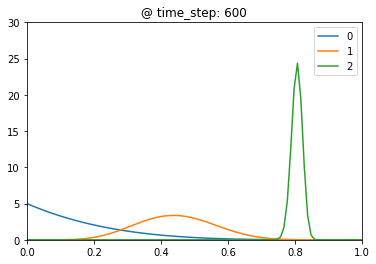

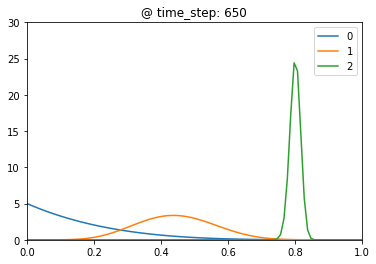

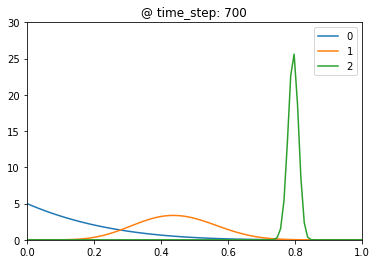

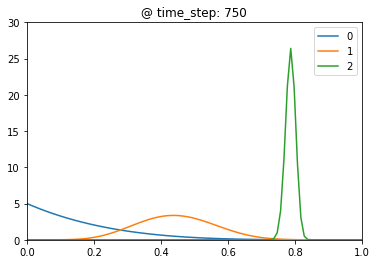

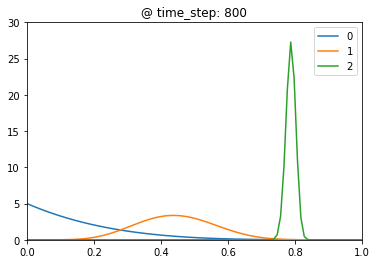

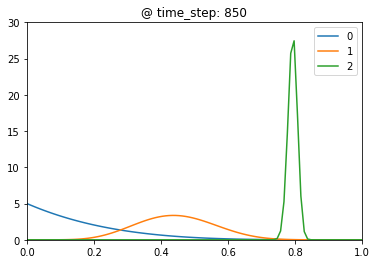

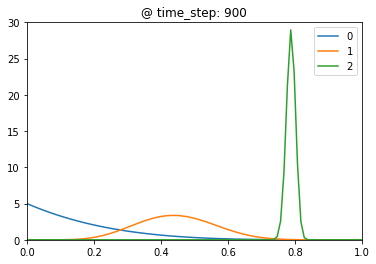

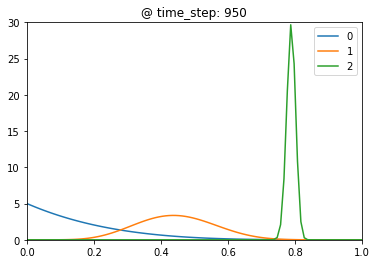

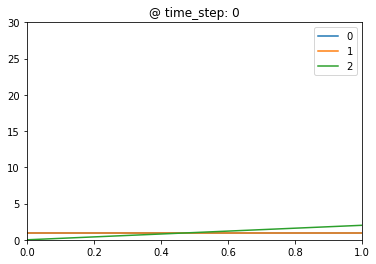

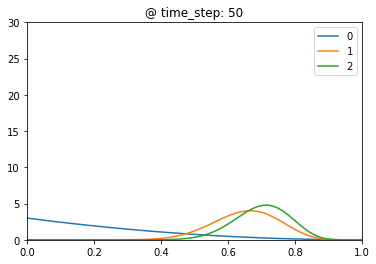

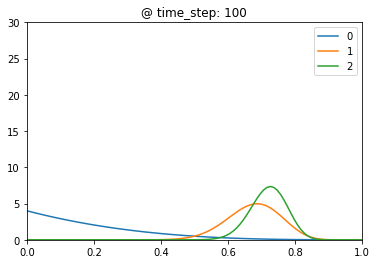

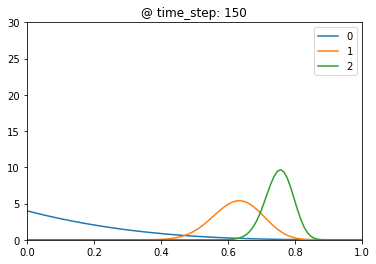

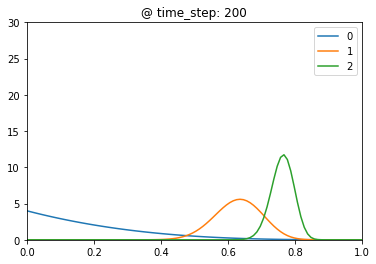

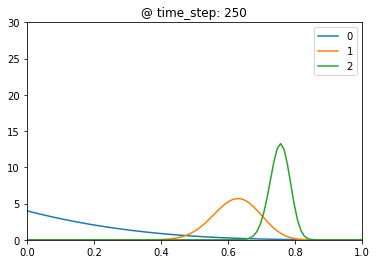

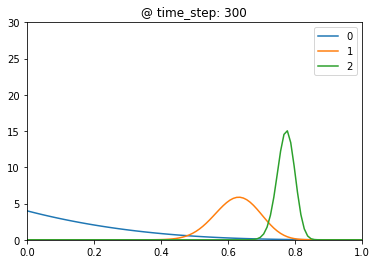

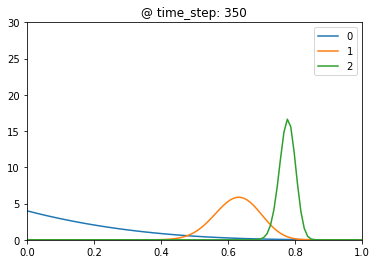

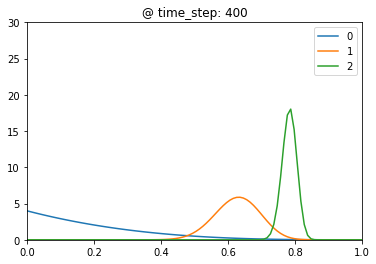

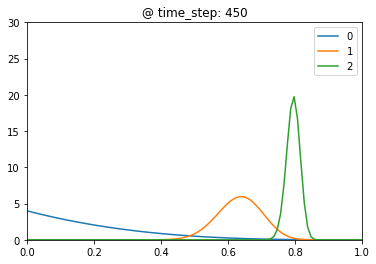

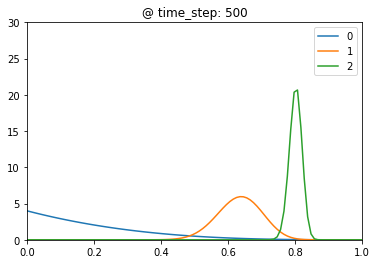

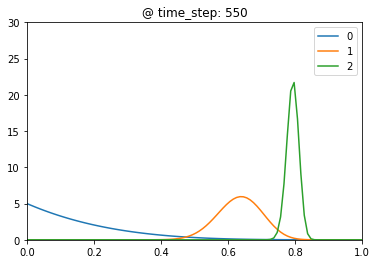

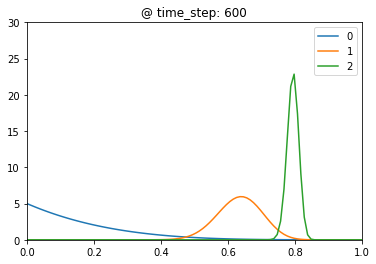

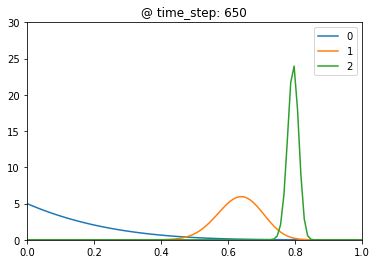

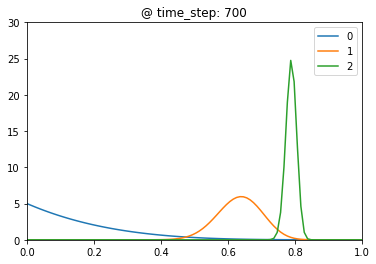

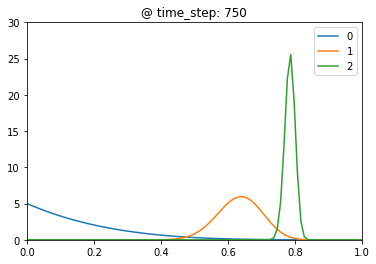

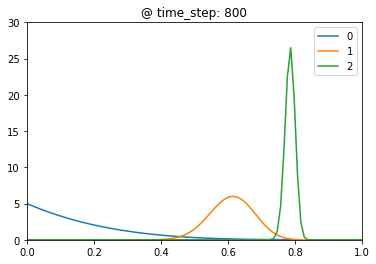

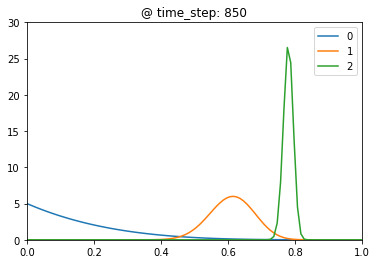

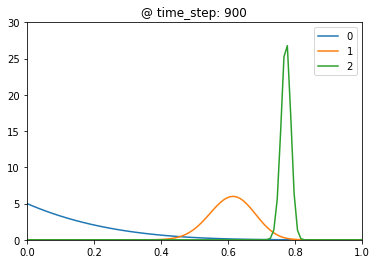

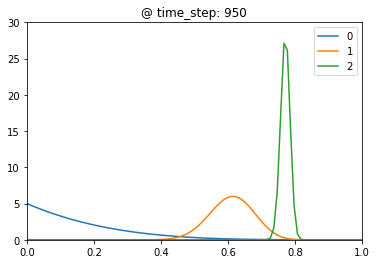

In [0]:
'''code to run the agent in the environment
'''

# exp setup
'''agent switch here / comment or uncomment the right one'''
agt = agent_thompson(env) # # agent_epsilon_greedy(env) | agent_thompson(env)
run_length = 1000 #3000 | 600
_trials=2
avg_regrets_for_trials = []
_rounds_per_trial = 2  # 2 | 5
regrets_for_rounds = []
''' verosity switch: 2 for debug + plots (no plots if using agent_epsilon_greedy because it's simple) | 1 for summary | 0 for clean '''
verbosity = 2


# init exp vars
best_possible_score = env.slots[np.argmax(env.slots)]*run_length
print('no_regret_score', best_possible_score)
controlled_exp_regret = best_possible_score - run_length*np.mean(env.slots)
print('base_case_regret', controlled_exp_regret)


for trials in range(_trials):
  for rounds in range(_rounds_per_trial):
    print()
    print()
    print('~~~~~~~~~~~~~~~~~~~~~~ROUND__{}~~~~~~~~~~~~~~~~~~~~~~~~'.format(rounds))
    print()
    print()
    for i in range(run_length):
      if (i%50 == 0 or i == 0) and verbosity>1:
        print('time_step', agt.time_step, '===========>')
        print('before update guesses', agt.so_far)
        act, rwd = agt.act()
        print('action / pulled bandit: ', act, 'got reward: ', rwd)
        agt.evaluate_n_update(act, rwd)
        print('updated guesses',agt.so_far)
        agt.draw_plot()
        print()
      else:
        act, rwd = agt.act()
        agt.evaluate_n_update(act, rwd)
    if verbosity > 0:
      print()
      print('agent total score', agt.total_score)
      print('agent final estimates', agt.so_far)
      print()


    regret = best_possible_score - agt.total_score
    print('regret_round_{} ='.format(rounds),  regret)
    regrets_for_rounds.append(regret)
    agt.reset()



  regret_diff =controlled_exp_regret - np.mean(regrets_for_rounds)
  print()
  print()
  print('trial_{} || base_case_regret - current_regret => less regret : '.format(trials), regret_diff, ' = ', controlled_exp_regret, ' - ', np.mean(regrets_for_rounds))
  print()
  print()
  avg_regrets_for_trials.append(np.mean(regrets_for_rounds))
                     
print('avg_regrets_for_all_trials', np.mean(avg_regrets_for_trials))



'''
Notes and Questions you should think about: 

- Observe the "guesses" being updated based on real time data
- Obsserve that the 'guesses' tend towards the true value that we have set in the env
- Verify for yourself that the agent never "knows" the true values other than what the stochastic environment is providing as rewards
- Which agent performs better? And why?
- What if you move the env params closer? If the difference is smaller, do we still converge to the right answer? When does this matter / not matter?
- What does the "peakiness" (kurtosis) of the various distribution mean? what does the horizontal location of the distribution mean?
'''

In [0]:
'''

At this point we can tell which button is better | which slot machine payes more and we can figure that out quickly / cost effectivly.
What else might we want to know?
My next question is always "but why though"?

The moment we ask why, we are in the land of causal inference... and trechery abounds. 
Because we've all heard "correlation isn't causation"

Do you buy the correlation? Is there any mechanism for causation here?
Lets see some examples: 
https://share.getcloudapp.com/BluNgOl7
https://share.getcloudapp.com/kpumk50g

Source: http://www.tylervigen.com/spurious-correlations | https://scikit-learn.org/stable/datasets/index.html#boston-dataset

How can we draw stronger conclusions and maybe understand hidden causes without letting ourselves get fooled?
We make a story for what causes what and how, and we test that.

'''

'\n\nAt this point we can tell which button is better and we can figure that out quickly.\nWhat else might we want to know?\nMaybe why the one performs better than others?\nThe moment we ask why, we are in the land of causal inference... and trechery abounds. \nBecause we\'ve all heard "correlation isn\'t causation"\n\nDo you buy the correlation? Is there any mechanism for causation here?\n\nLets see some examples: \nhttps://share.getcloudapp.com/BluNgOl7\nhttps://share.getcloudapp.com/kpumk50g\n\nSource: http://www.tylervigen.com/spurious-correlations | https://scikit-learn.org/stable/datasets/index.html#boston-dataset\n\nHow can we draw stronger conclusions and maybe understand hidden causes without letting ourselves get fooled?\n\n'

In [0]:
# %debug

!sudo apt-get install graphviz libgraphviz-dev pkg-config
!pip install dowhy pygraphviz

# import os
# os._exit(00)


Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
graphviz is already the newest version (2.40.1-2).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-drivers cuda-license-10-2 cuda-npp-10-1
  cuda-npp-dev-10-1 cuda-nsight-10-1 cuda-nsight-compute-10-1
  cuda-nsight-systems-10-1 cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1
  cuda-nvjpeg-10-1 cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1
  cuda-nvvp-10-1 default-jre dkms freeglut3 freeglut3-dev
  keyboard-configuration libargon2-0 libcap2 libcryptsetup12 libcublas10
  libdevmapper1.02.1 libfontenc1 libidn11 libip4tc0 libjansson4
  libnvidia-cfg1-440 libnvidia-common-430 libnvidia-common-440
  libnvidia-decode-440 libnvidia-encode-4

In [0]:


import dowhy
from dowhy.do_why import CausalModel

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

'''
info about the data set: https://www.kaggle.com/c/boston-housing | https://scikit-learn.org/stable/datasets/index.html#boston-dataset
'''



'\ninfo about the data set: https://www.kaggle.com/c/boston-housing | https://scikit-learn.org/stable/datasets/index.html#boston-dataset\n'

In [0]:
import pandas as pd
import numpy as np
df = pd.DataFrame(list(X), columns=['crime', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', '_', 'marginalized_pop'])
df['px'] = y

In [0]:
# gets the 70th percentile of a column
np.percentile(df.marginalized_pop,70)

# define now columns for "high_marginalized_pop" and "high_crime"
df['high_marg']=df.marginalized_pop.apply(lambda x: 1 if x > np.percentile(df.marginalized_pop,70) else 0)
df['high_crime']=df.crime.apply(lambda x: 1 if x > np.percentile(df.marginalized_pop,70) else 0)

In [0]:
y[:20]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2])

In [0]:
# this is a underpowered model and we expect this to perform badly
m1_high_marg_incomplete=CausalModel(
        data=df,
        treatment='high_marg',
        outcome='px',
        common_causes=['crime',
                       'chas',
                        'nox'])
# what if we considerd the impact of varaibles on crime and use high_crime area as a treatment for price
# maybe higher 'marginalized_pop' leads to higher crime rates and that affects prices?
m2_high_crime=CausalModel(
        data=df,
        treatment='high_crime',
        outcome='px',
        common_causes=['marginalized_pop',
                       'chas',
                        'nox',
                      'rm', 'dis'])

# what if we considerd the impact of varaibles on crime and use high_crime area as a treatment for price
# maybe higher 'crime' leads to higher marginalized_population and that affects prices?
m3_high_marg_improved=CausalModel(
        data=df,
        treatment='high_marg',
        outcome='px',
        common_causes=['crime',
                       'chas',
                        'nox',
                      'rm', 'dis'])

INFO:dowhy.do_why:Model to find the causal effect of treatment ['high_marg'] on outcome ['px']
INFO:dowhy.do_why:Model to find the causal effect of treatment ['high_crime'] on outcome ['px']
INFO:dowhy.do_why:Model to find the causal effect of treatment ['high_marg'] on outcome ['px']


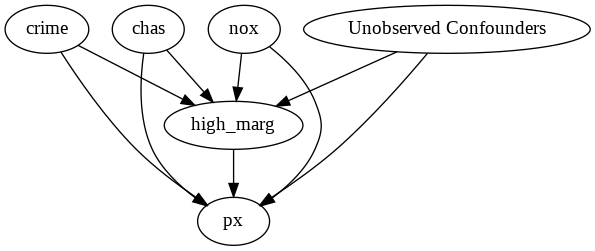

In [0]:
from IPython.display import Image, display

m1_high_marg_incomplete.view_model(layout="dot")
display(Image(filename="causal_model.png"))

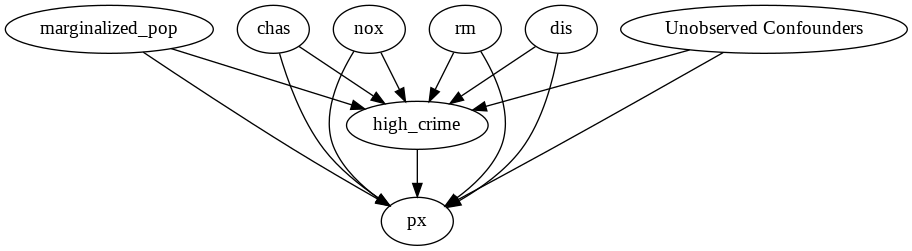

In [0]:
from IPython.display import Image, display

m2_high_crime.view_model(layout="dot")
display(Image(filename="causal_model.png"))

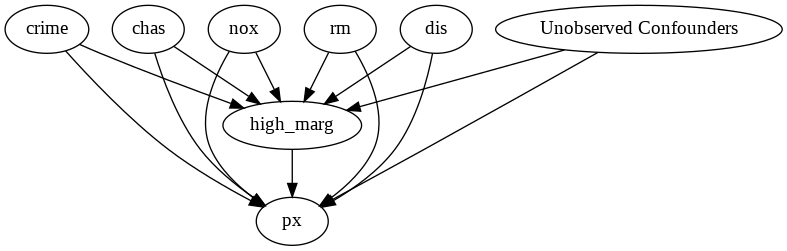

In [0]:
from IPython.display import Image, display

m3_high_marg_improved.view_model(layout="dot")
display(Image(filename="causal_model.png"))

In [0]:
from google.colab.output._publish import javascript
url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"


In [0]:


identified_estimand_m1 = m1_high_marg_incomplete.identify_effect(proceed_when_unidentifiable=True)
estimate_m1 = m1_high_marg_incomplete.estimate_effect(identified_estimand_m1, method_name="backdoor.propensity_score_matching")
print()
print('m1_high_marg_incomplete',estimate_m1.value)

identified_estimand_m2 = m2_high_crime.identify_effect(proceed_when_unidentifiable=True)
estimate_m2 = m2_high_crime.estimate_effect(identified_estimand_m2, method_name="backdoor.propensity_score_matching")
print()
print('m2_high_crime',estimate_m2.value)

identified_estimand_m3 = m3_high_marg_improved.identify_effect(proceed_when_unidentifiable=True)
estimate_m3 = m3_high_marg_improved.estimate_effect(identified_estimand_m3, method_name="backdoor.propensity_score_matching")
print()
print('m3_high_marg_improved',estimate_m3.value)
print()
print(estimate_m3)


INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['crime', 'chas', 'nox', 'U']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_marg+crime+chas+nox
/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['rm', 'marginalized_pop', 'chas', 'U', 'dis', 'nox']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental 


m1_high_marg_incomplete -7.699342105263158

m2_high_crime -5.611538461538462


/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()



m3_high_marg_improved -6.588815789473684

*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                            
──────────(Expectation(px|crime,rm,chas,dis,nox))
dhigh_marg                                       
Estimand assumption 1, Unconfoundedness: If U→high_marg and U→px then P(px|high_marg,crime,rm,chas,dis,nox,U) = P(px|high_marg,crime,rm,chas,dis,nox)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: px~high_marg+crime+rm+chas+dis+nox
## Estimate
Value: -6.588815789473684



![](http://nickchk.com/anim/Animation%20of%20Matching.gif)


source / resource : https://nickchk.com/causalgraphs.html


In [0]:
refute_res_random1 = m1_high_marg_incomplete.refute_estimate(identified_estimand_m1, estimate_m1,
                                       method_name="random_common_cause")
print(refute_res_random1)

print()

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_marg+nox+chas+crime+w_random


Refute: Add a Random Common Cause
Estimated effect:(-7.699342105263158,)
New effect:(-7.103947368421055,)




/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [0]:
refute_res_random3 = m3_high_marg_improved.refute_estimate(identified_estimand_m3, estimate_m3,
                                       method_name="random_common_cause")
print(refute_res_random3)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_marg+nox+crime+rm+chas+dis+w_random


Refute: Add a Random Common Cause
Estimated effect:(-6.588815789473684,)
New effect:(-9.041447368421057,)



/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [0]:
refute_res_placebo1 = m1_high_marg_incomplete.refute_estimate(identified_estimand_m1, estimate_m1,
                                       method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_res_placebo1)


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~placebo+nox+chas+crime
/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


Refute: Use a Placebo Treatment
Estimated effect:(-7.699342105263158,)
New effect:(0.03157894736842134,)



In [0]:
refute_res_placebo3 = m3_high_marg_improved.refute_estimate(identified_estimand_m3, estimate_m3,
                                       method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_res_placebo3)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~placebo+nox+crime+rm+chas+dis


Refute: Use a Placebo Treatment
Estimated effect:(-6.588815789473684,)
New effect:(-0.8032894736842117,)



/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [0]:
refute_res_subset1 = m1_high_marg_incomplete.refute_estimate(identified_estimand_m1, estimate_m1,
                                      method_name="data_subset_refuter", subset_fraction=0.8)
print(refute_res_subset1)


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_marg+nox+chas+crime


Refute: Use a subset of data
Estimated effect:(-7.699342105263158,)
New effect:(-6.870833333333336,)



/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [0]:
refute_res_subset3 = m3_high_marg_improved.refute_estimate(identified_estimand_m3, estimate_m3,
                                       method_name="data_subset_refuter", subset_fraction=0.8)
print(refute_res_subset3)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_marg+nox+crime+rm+chas+dis


Refute: Use a subset of data
Estimated effect:(-6.588815789473684,)
New effect:(-7.073333333333335,)



/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [0]:
print()

refute_res_random2 = m2_high_crime.refute_estimate(identified_estimand_m2, estimate_m2,
                                       method_name="random_common_cause")
print(refute_res_random2)

print()

refute_res_placebo2 = m2_high_crime.refute_estimate(identified_estimand_m2, estimate_m2,
                                       method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_res_placebo2)

print()

refute_res_subset2 = m2_high_crime.refute_estimate(identified_estimand_m2, estimate_m2,
                                       method_name="data_subset_refuter", subset_fraction=0.8)
print(refute_res_subset2)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_crime+nox+dis+marginalized_pop+chas+rm+w_random
/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~placebo+nox+dis+marginalized_pop+chas+rm
/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_crime+nox+dis+marginalized_pop+chas+rm



Refute: Add a Random Common Cause
Estimated effect:(-5.611538461538462,)
New effect:(-4.026923076923077,)


Refute: Use a Placebo Treatment
Estimated effect:(-5.611538461538462,)
New effect:(-3.1153846153846154,)


Refute: Use a subset of data
Estimated effect:(-5.611538461538462,)
New effect:(-3.9588235294117653,)



/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


In [0]:
print()

refute_res_random3 = m3_high_marg_improved.refute_estimate(identified_estimand_m3, estimate_m3,
                                       method_name="random_common_cause")
print(refute_res_random3)

print()

refute_res_placebo3 = m3_high_marg_improved.refute_estimate(identified_estimand_m3, estimate_m3,
                                       method_name="placebo_treatment_refuter", placebo_type="permute")
print(refute_res_placebo3)

print()

refute_res_subset3 = m3_high_marg_improved.refute_estimate(identified_estimand_m3, estimate_m3,
                                       method_name="data_subset_refuter", subset_fraction=0.8)
print(refute_res_subset3)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_marg+nox+crime+rm+chas+dis+w_random
/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~placebo+nox+crime+rm+chas+dis



Refute: Add a Random Common Cause
Estimated effect:(-6.588815789473684,)
New effect:(-7.401315789473684,)




/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: px~high_marg+nox+crime+rm+chas+dis
/usr/local/lib/python3.6/dist-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()


Refute: Use a Placebo Treatment
Estimated effect:(-6.588815789473684,)
New effect:(-0.055263157894737104,)


Refute: Use a subset of data
Estimated effect:(-6.588815789473684,)
New effect:(-7.687394957983191,)

